# IBM DATA SCIENCE PROFESSIONAL CERTIFICATE CAPSTONE PROJECT - PART 2️⃣

# Introduction 🎢

This is the second of two Jupyte Notebooks for the so called *Capstone Project - The Battle of Neighborhoods* developed and teached by IBM on Coursera. It comprises assignment solution for Week 5.

# Coding Fun 🏖️💻

_Let's import the usual suspects_ 🧙‍♀️🧛🏻‍♂️🧟‍♂️ 🤓:

In [386]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import time # simple timer

_... and some new friends_  🦕🐢🐙🐿️:

In [13]:
import geocoder
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if not installed on your system
from geopy.geocoders import Nominatim # convert an address into latitude and l ongitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas d ataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if not installed on your system
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Load Data
### 1️⃣ from 💾 👉 `Capstone-Project-Part_1.ipyn`

In [14]:
df= pd.read_pickle("data/df_with_venues.pkl")

In [15]:
df.columns

Index(['Postcode', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Bourough',
       'Neighbourhood', 'Latitude', 'Longitude'],
      dtype='object')

In [16]:
df.head(2)

,Postcode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Bourough,Neighbourhood,Latitude,Longitude
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,Scarborough,"[Rouge, Malvern]",43.806686,-79.194353
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,Scarborough,"[Highland Creek, Rouge Hill, Port Union]",43.784535,-79.160497


In [17]:
df.shape

(2225, 11)

### 2️⃣ from 🌐 👉[Toronto Neighbourhood Profiles](https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv)

In [18]:
# only download if not in folder data
try:
    toronto_df = pd.read_csv("data/neighbourhood-profiles-2016-csv.csv")
except:
    url="https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv"
    toronto_df = pd.read_csv(url) #scrape from wikipedia

In [19]:
toronto_df.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


The data is on neighbourhood level.

In [20]:
neighbourhoods_toronto = toronto_df.columns[6:]
print ("Neighbourhoods in toronto_df:", len(neighbourhoods_toronto))

Neighbourhoods in toronto_df: 140


In [21]:
neighbourhoods_df = set()
for cell in df.Neighbourhood:
    for item in cell:
        neighbourhoods_df.add(item)
print ("Neighbourhoods in neighbourhoods_df:", len(neighbourhoods_df))

Neighbourhoods in neighbourhoods_df: 199


🤔 _Uuups! Why do we have more neighbourhoods in our old dataset?_

#### Let's find out which neigbourhoods are in which dataset

In [22]:
# Neighbourhoods in our data but not in Toronto dataset
t1 = {i for i in neighbourhoods_df  if i not in neighbourhoods_toronto}
len(t1)

164

In [23]:
# Neighbourhoods  in Toronto dataset but not in our dataset
t2 = {i for i in neighbourhoods_toronto if i not in neighbourhoods_df}
len(t2)

105

❗ _Okay. That's a lot. This is more than just a few typos or the use or not-use of "The" could explain .._

---

# Find best Business Location

Datatype:  <class 'shapely.geometry.polygon.Polygon'>
Shape of Toronto:


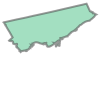

In [498]:
import geopandas as gpd
# download/load city boundary (geo shape) of Toronto
# https://open.toronto.ca/dataset/regional-municipal-boundary/
toronto_shape = gpd.read_file("data/toronto-boundary-wgs84/citygcs_regional_mun_wgs84.shp")
poly = toronto_shape.geometry

print("Datatype: ", type(poly.iloc[0]) )
print("Shape of Toronto:")
poly.iloc[0]

In [499]:
# Function for checking if point within geo shape

def point_inside_polygon(lat,lng,poly):
    # Reference for code in function(++)
    '''
    INPUT - lat, long - int - latitude and longitude
            list - list of geo shapes coordinates (list of latitudes longitudes)
    OUTPUT - True, False - coordinate within shape or not
    '''
    n = len(poly)
    inside =False
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if lat > min(p1y,p2y):
            if lat <= max(p1y,p2y):
                if lng <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (lat-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or lng <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

(++) Reference: [Working with Open Data shape files using Geopandas — how to match up your data with the areas defined in the shape file](https://medium.com/dataexplorations/working-with-open-data-shape-files-using-geopandas-how-to-match-up-your-data-with-the-areas-9377471e49f2)

In [500]:
# check random point
shape_list = list(np.asarray(poly.iloc[0].exterior.coords))
point_inside_polygon(43.62580,-79.33131,shape_list)

True

### Sanity Check: all Venues are within City Boundary?

In [286]:
# Venue Categories
venue_cat = df.groupby("Venue Category").count()["Venue"]
print(venue_cat.sort_values(ascending=False).head())

# sample as numpy
venue_sample="Gym"
v = df[df["Venue Category"]==venue_sample][["Venue Latitude","Venue Longitude"]].values
print("-------------")
print("Sample Venue: ", venue_sample)
print("Shape of Sample Array: ", v.shape)

Venue Category
Coffee Shop    181
Café           102
Restaurant      73
Park            56
Bakery          52
Name: Venue, dtype: int64
-------------
Sample Venue:  Gym
Shape of Sample Array:  (33, 2)


In [371]:
# check all our venues if really within Toronto City Boundary
start_timer = time.time()
venues_outside_list = [] # list of venues which are outside Toronto
for index, row in df.iterrows():
    x = point_inside_polygon(row['Venue Latitude'], row['Venue Longitude'], shape_list)
    if x==False:
        venues_outside_list.append(index)
        print ("{} at {},{}".format(
            row["Venue"], 
            row['Venue Latitude'], 
            row['Venue Longitude'] ) )
        
stop_timer = time.time()
print("Duration: {} for {} venues".format(int(stop_timer-start_timer), df.shape[0]))

Duration: 67 for 2212 venues


In [137]:
# Let's delete these venues from Dataframe
df.drop(df.index[venues_outside_list],inplace=True)

## Find best Location for Venue Category

🏁 The goal is to find that point (location) within the Toronto city boundary which is most distant from the same venue category.

In [507]:
# CREATE ARRAY OF SAMPLE POINTS IN TORONTO

xy_min = [np.asarray(poly.iloc[0].exterior.coords)[:,1].min(),
         np.asarray(poly.iloc[0].exterior.coords)[:,0].min()]

xy_max = [np.asarray(poly.iloc[0].exterior.coords)[:,1].max(),
         np.asarray(poly.iloc[0].exterior.coords)[:,0].max()]
rectangle = (xy_min,xy_max)
print("Rectangle: ",rectangle)

# make np.array of equally distributed lat-long-coordinates
N=100 #how many points in space
# ratio = (rectangle[1][0]-rectangle[0][0]) / (rectangle[1][1]-rectangle[0][1]) #lat:long
lat_samples = np.linspace(rectangle[0][0],rectangle[1][0], 10) #create 10 equally distributed points within latitude range
lat_samples = list(lat_samples)*10
long_samples = np.linspace(rectangle[0][1], rectangle[1][1], N)
long_samples = list(long_samples)*10

coord_samples = np.array(list(zip(lat_samples, long_samples)))
print("Shape of Sample Points: ", coord_samples.shape)

Rectangle:  ([43.58100456, -79.63926826], [43.85546581, -79.11524635])
Shape of Sample Points:  (100, 2)


In [543]:
#coord_samples
v.shape
s_=coord_samples[1,:]
dist = np.sum( np.abs(s_-v), axis=1 )
x = np.concatenate((v,dist.reshape(v.shape[0],1)),axis=1)
x = x[x[:,2].argmin()]

array([ 43.61150025, -79.63397511])

In [615]:
# Manhattan Distance L1
# out: numpy array of size x,3
def distance(v, s_):
    '''INPUT  v - np.array  - venue categories (n,2) 33x2
       INPUT s_ - np.array - sample x,y point (1,2) 33x2
       OUTPUT x - x,y-value 
    '''
    # Manhattan Distance between every sample point and venue
    dist = np.sum(np.abs(np.abs(s_)-np.abs(v)), axis=1 ) #33,
    #dist = np.abs(s_-v), axis=1)
    x = np.concatenate((v,dist.reshape(v.shape[0],1)),axis=1)
    return x[x[:,2].argmin()] # get row with smalles distance

In [617]:
# calculate array of points and distances
start_timer = time.time()
b = []
for row in coord_samples:
    j = distance(v, row)
    # check if point is within city boundary:
    #if point_inside_polygon( j[0],j[1], shape_list):
    b.append(j)
results = np.array(b)

stop_timer = time.time()
print("Duration: {}s for {} distances".format(int(stop_timer-start_timer), results.shape[0]))

Duration: 0s for 44 distances


In [618]:
results
winner = results[results[:,2].argmax()]
winner[0]

43.72747286430573

In [657]:
# filter out of city samples
new = []
for row in coord_samples:
    inside = point_inside_polygon( row[0],row[1], shape_list)
    if inside:
        new.append(row)

In [660]:
def calculate_dist(point, venues):
    h = np.ones(venues.shape)*point
    d=np.sum(np.abs(np.abs(h)-np.abs(venues)),axis=1)
    return d.min() #distance between that point and nearest venue

temp=[]
for point in new:
    temp.append( calculate_dist(point, v))
index = np.array(temp).argmax()
winner = coord_samples[index]

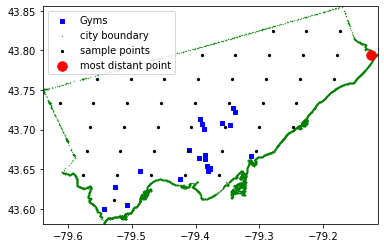

In [663]:
# Plot city boundary, venue categories, results

ven = pd.DataFrame(v, columns=["long","lat"])
dx=pd.DataFrame(results, columns=["long","lat","dist"])
samp = pd.DataFrame(new,columns=["lat","long"])


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(ven.lat, ven.long, s=10, c='b', marker="s", label='Gyms')
ax1.scatter(s.long,s.lat, s=0.1, c='g', label='city boundary')
ax1.scatter(samp.long,samp.lat, s=5, c='black', label='sample points')
ax1.scatter(winner[1], winner[0],s=90, c='red', label='most distant point')

# Set Rectangle (within our sample points are) as x- and y-axis
ax1.set_ylim([rectangle[0][0], rectangle[1][0]])
ax1.set_xlim([rectangle[0][1], rectangle[1][1]])
plt.legend(loc='upper left');
plt.show()

## Get Information about our new location

-👷🏻‍♂️will be future work -

---
# 🔚 🙏🏼 🙋🏻‍♂️

## _Thank You_ ... `for Your attention 📺`  ✌️